In [40]:
# imports required to run the code.
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import sklearn
import autograd.numpy as np_
import numpy as np
from autograd import grad

# Preparando o DataSet

Antes de começarmos a aplicar nosso classificador, precisamos ter certeza que ele estrá usando dados válidos, para isso executamos os seguintes passos:

- remoção de valores corrompidos/perdidos.
- ordenação. (para visualização e debugging mais eficientes)
- remoção de valores redundantes
- renomeação de 'gender_female'para female visto a futura remoção de 'gender_Male'.


In [41]:
# troca de valores NaN por 0's, afim de evitar erros.

dfo = pd.read_csv('healthcare-dataset-stroke-data.csv')
dfo = dfo.fillna(0)

# ---------------------------------------- #

dfo.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,0.0,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [42]:
# ordenando e reaplicando index.

dfo = dfo.sort_values(by=['bmi'], ascending=True)
dfo = dfo.reset_index(drop = True)

# ---------------------------------------- #

df = pd.get_dummies(dfo) # converte dados não numéricos em dados numéricos.
df.rename(columns={"gender_Female": "female"}, inplace = True)

# ---------------------------------------- #

df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,34248,50.0,1,0,81.96,0.0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,29224,30.0,0,0,91.23,0.0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
2,49894,78.0,1,1,206.53,0.0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,37526,68.0,1,1,233.30,0.0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
4,29095,71.0,1,0,93.60,0.0,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0


## Sobre dados redundantes

- podem ser obtidos a partir a junção de outras caracteristicas do dataframe, tendo menos informação a acrecentar ao modelo.
- são opostos diretos a algum outro elemento, tornando-os desnecessários visto o modelo binário de interpretação.

### Respectivos exemplos

- como sabemos se alguém nunca fumou (smoking_status_never smoked) e temos o estado atual (smoking_status_smokes) e uma medida que aponta falta de dados (smoking_status_Unknown), não precisamos saber se alguém já fumou, visto que é possivel extrapolar esse dado atráves das medidas previamente citadas.
- como temos ambos (gender_Male) e (gender_Female) indicados atráves de um valor binário, podemos eliminar um deles.

In [43]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

# Amostragem

Uma vez que temos dados válidos, o primeiro passo para garantir uma análise mais próxima da realidade é a remoção de parcialidades, no nosso caso, identificamos que nossos dados eram majoritariamente de pessoas que não sofreram de AVC's, portanto havia um viés tendendo a essa direção o que poderia reduzir a credibilidade de nosso algoritmo.

Para contornar tal problema, decidimos limitar nosso tamanho de amostra para que houvesse uma relação mais próxima de 1 para 1 entre casos em que um individuo sofreu ou não um AVC. 

In [44]:
# normalizando a distribuição de dados.

filtery = (df['stroke'] == 0)
dfo1 = df[filtery]

dfo1 = dfo1.iloc[:300]

filtery = (df['stroke'] == 1)
dfo2 = df[filtery]

dfo = dfo1.append(dfo2)

# ----------------- #

C:\Users\Pedro Antônio Silva\AppData\Local\Temp\ipykernel_1536\2488603706.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfo = dfo1.append(dfo2)


In [45]:
# como esclarecido na seção 'Preparando o DataSet' removemos dados redundantes aqui.
dfa = dfo.drop(columns=['stroke','id','ever_married_No','Residence_type_Rural','smoking_status_formerly smoked']).astype(float)

## Separando dados em teste e treino

Utilizando a biblioteca python sklearn para separar mais rapidamente.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(dfa, dfo['stroke'], train_size=0.5)
y_train = y_train.replace(to_replace=0,value=-1)
y_test = y_test.replace(to_replace=0,value=-1)
y_train.value_counts()

-1    151
 1    123
Name: stroke, dtype: int64

In [47]:
# Mudança para numpy feita para o código registrar os calculos corretamente.
X_train,X_test,y_train,y_test = X_train.to_numpy(),X_test.to_numpy(),y_train.to_numpy(),y_test.to_numpy()

# Métodos e funções
Com base em nosso modelo, para o qual assumimos um funcionamento linear, ou seja :
$$
Y = Ax + B
$$
Usamos as seguintes funções


- predict():
    - utiliza as medidas obtidas através da regressão linear para 'adivinhar' se alguém terá ou não um AVC

- acurracy():
    - calcula a acurácia do algoritmo, obtida através da comparação entre os dados e a obtenção da média. 

- eqm():
    - calcula o erro quadrático médio, obtido atráves da predição dos valores atráves da formula linear com valores incorretos e compara com os valores corretos. Os gradientes gerados atráves do calculo do eqm com o gradle representam o sentido que esses valores estão em realação ao valor real (- se é menor e + se for maior) sendo o eqm expresso pela equação:

$$
\text{EQM} = \frac{1}{N} \sum_{n=1}^N (y_n - (ax_n + b))^2
$$

In [49]:
# ---------------------------------------- #

def predict( w, b, pontos ):
    est = w.T @ pontos + b
    return est


def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test) == np.sign(y_est))

def eqm( parametros ): # 
    w, b, pontos, val = parametros
    est = w.T @ pontos + b
    mse = np_.mean( (est - val)**2)
    return mse

# ---------------------------------------- #

# Aplicando regressão linear para predizer AVC's

Para realizar nossas predições com uma regressão linear, nós utilizaremos principalmente dos gradientes obtidos através da função eqm aplicada com o gradle. Estes gradientes serão multiplicados por alpha e subtraidos do valor inicial de ambos, afim de aproximar o valor inicial da realidade do modelo. Realizar esse processo repetidas vezes é o que define e regressão linear, visto que modificamos os valores a e b (w e b) estimados com o gradiente e recalculamos, afim de gerar o EQM desses novos valores. Continua sendo uma aproximação, mas transforma os valores iniciais em estimativas de maior precisão quanto mais iterações houver, visto que modifica o valor por alpha no setido que o gradiente delimita (aponta para o valor real)

In [48]:
g = grad(eqm)

pontos = X_train.T
alvos = (y_train).astype(float)

w = np.random.randn( pontos.shape[0],1)
b = 0.0
alpha = 0.000001

for n in range(10000):
    grad_ = g( (w, b, pontos, alvos) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]

y_pred = (predict( w, b, X_test.T )).reshape((y_test.shape))

- sobre o código:
    - alpha define o tamanho do passo dado em direção ao gradiente.
    - o laço for pode ter mais iterações afim de atinjir a precisão descrita em markdom e no Read.me, os parametros atuais são de demonstração.

# Teste de acurácia

Antes de analisarmos os resultados de nosso código, precisamos primeiro nos certificar de sua precisão, para isso iteramos sobre ele algumas vezes e calculamos a média e o desvio padrão na acurácia de nosso algoritmo. 

In [50]:
# Generating data for accuracy test.
# Current values are going to take a while.

results = []
for _ in range(10):
    g = grad(eqm)

    pontos = X_train.T
    alvos = (y_train).astype(float)

    w = np.random.randn( pontos.shape[0],1)
    b = 0.0
    alpha = 0.000001

    for n in range(10000):
        grad_ = g( (w, b, pontos, alvos) )
        w -= alpha*grad_[0]
        b -= alpha*grad_[1]

    y_pred = (predict( w, b, X_test.T )).reshape((y_test.shape))

    results.append(accuracy(y_test, y_pred))

In [51]:
# prints accuracy data.

print(np.array(results).mean())
print(np.array(results).std())

0.5385454545454545
0.0850077293520229


Com base nos parametros normalisados, podemos afirmar que nosso classificador tem um funcionamento teórico decente - acertando em media 60% das vezes, dito isso, vamos ao próximo ponto de interesse - o que causa esses resultados?

## Valores de predição

O valor w usado nas equações prévias, contem uma sequência de valores que ao fim das iterações do código, armazena a relevância do fator relacionado a ocorrência de AVC's, devido a ser o valor que modifica X diretamente representando então a força da relação entre um atributo e o resultado positivo.


In [52]:
# Generating prediction values.

g = grad(eqm)

pontos = X_train.T
alvos = (y_train).astype(float)

w = np.random.randn( pontos.shape[0],1)
b = 0.0
alpha = 0.000001
for n in range(1000):
    grad_ = g( (w, b, pontos, alvos) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]

y_pred = (predict( w, b, X_test.T )).reshape((y_test.shape))
print(w)

[[-0.33108909]
 [ 2.0429559 ]
 [-2.95839899]
 [ 0.04529863]
 [ 0.63291731]
 [ 0.14308815]
 [ 0.60482542]
 [ 0.22335938]
 [ 0.88280446]
 [-0.89883186]
 [ 0.44007278]
 [ 0.10830283]
 [-0.39469275]
 [ 0.26547176]
 [ 0.50181882]
 [ 0.55425237]
 [-1.3859905 ]
 [ 0.14321322]]


# Visualizando os fatores de relevância

In [53]:
from collections import OrderedDict

columns = list(dfa.columns)
res = {columns[i]: float(w[i]) for i in range(len(w))}
sorted(res.items(), key=lambda t: t[1], reverse=True)

[('hypertension', 2.042955897187031),
 ('ever_married_Yes', 0.8828044558044229),
 ('bmi', 0.6329173132878163),
 ('gender_Male', 0.6048254155783426),
 ('smoking_status_Unknown', 0.554252369952714),
 ('Residence_type_Urban', 0.5018188190502407),
 ('work_type_Never_worked', 0.4400727834809154),
 ('work_type_children', 0.26547175775993853),
 ('gender_Other', 0.2233593753517959),
 ('smoking_status_smokes', 0.14321322071135273),
 ('female', 0.1430881500585865),
 ('work_type_Private', 0.10830283298205524),
 ('avg_glucose_level', 0.04529863108505537),
 ('age', -0.3310890874971538),
 ('work_type_Self-employed', -0.394692753178162),
 ('work_type_Govt_job', -0.8988318575855301),
 ('smoking_status_never smoked', -1.3859904969581418),
 ('heart_disease', -2.9583989902020247)]

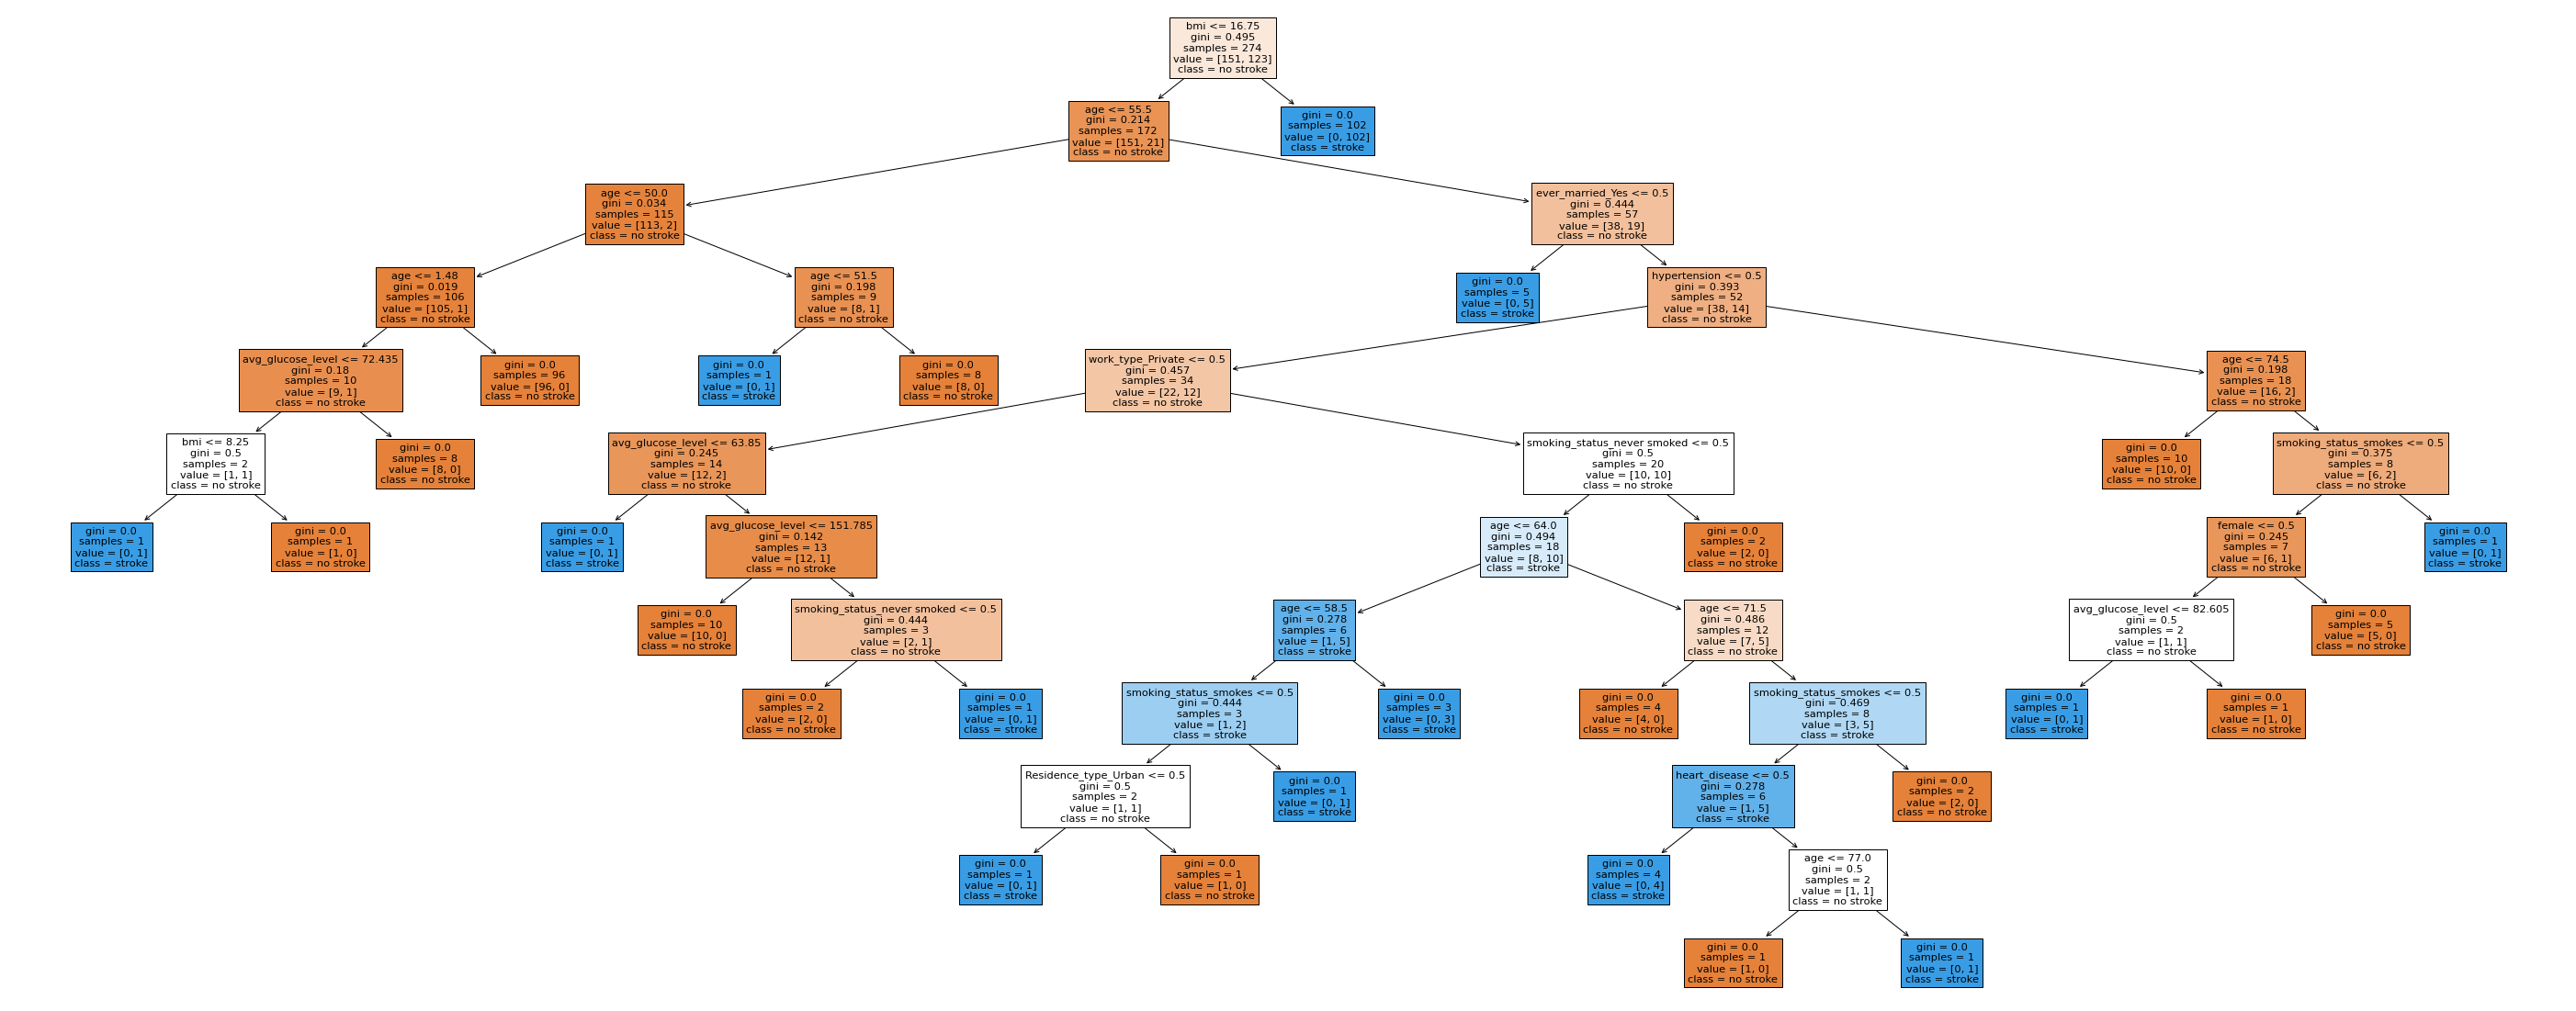

In [54]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(50, 20))
plot_tree(model, feature_names=dfa.columns, class_names=['no stroke', 'stroke'], filled=True, ax=ax)
plt.show()